# Two approaches in dealing with uncertainty
A Bayesian and Frequentist approach to prediction uncertainty. In both cases, I want to define both aleatoric and epistemic uncertainty.

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

from src.data import generate_dataset
from src.visualization import beautify_ax
from src.model import (
    ModelTrainer, BayesianLinearRegression, 
    QuantileRegressionMCDropoutNet, HeteroscedasticMCDropoutNet
)
from src.model.quantile_utils import create_quantiles

%load_ext autoreload
%autoreload 2

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
sns.set_style("white")
cs = sns.color_palette(n_colors=3)

## Generating data

In [4]:
np.random.seed(42)
x, x_test, y, y_test = generate_dataset(n=500, test_size=.2)

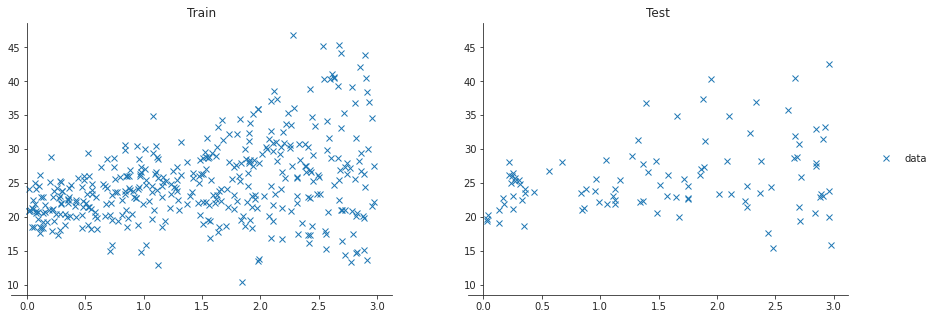

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,5))

axes[0] = beautify_ax(axes[0])
axes[0].plot(x, y, 'x', label='data')
axes[0].set_title("Train")

axes[1] = beautify_ax(axes[1])
axes[1].plot(x_test, y_test, 'x', label='data')
axes[1].set_title("Test")

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));

## Create our `ModelTrainer` with all models we would like to compare
- `QuantileRegressionMCDropoutNet` (more info, check notebook: '1.0_deep_quantile_regression.ipynb')
- `BayesianLinearRegression` (more info, check notebook: '1.1_bayesian_linear_regression.ipynb')
- `HeteroscedasticMCDropoutNet` (more info, check notebook: '1.2_heteroscedastic_mcdropout.ipynb')

All modelclasses have been structured with a SKlearn-like interface. This allows me to create modeltrainer and interact with the models in a similar(equal) way.

In [6]:
QUANTILES = create_quantiles(11, min_q=0.01, max_q=0.99)
QRMCDN_params = {'input_size': 1, 'hidden_size': 128, 'dropout_p': 0.2, 'quantiles': QUANTILES, 'dropout_dim': 1}
HMCDN_params  = {'input_size': 1, 'hidden_size': 256, 'dropout_p': 0.2}
BLR_params    = {'input_size': 1}

models = {
    "QRMCDN": QuantileRegressionMCDropoutNet(QRMCDN_params),
    "HMCDN": HeteroscedasticMCDropoutNet(HMCDN_params),
    "BLR": BayesianLinearRegression(BLR_params)
}

trainer = ModelTrainer(models, model_path='../models/')

## Make the `trainer` train!

In [7]:
fit_kwargs = {
    "QRMCDN": {'batch_size': 128, 'epochs': 2001, 'print_iter': 100, 'lr': 1e-4},
    "HMCDN": {'batch_size': 16, 'epochs': 2001, 'print_iter': 100, 'lr': 1e-4, 'weight_decay': 1e-6},
    "BLR": {'samples': 1000, 'tune':1000, 'init':'adapt_diag', 'nuts_kwargs': {'target_accept': 0.9}}
}

save_kwargs = {
    "BLR": {'overwrite': True}
}
trainer.train(x, y, fit_kwargs, save_kwargs)

INFO:src.model.model_trainer:Start training QRMCDN
INFO:src.model.model_trainer:Done training QRMCDN and saved to file.
INFO:src.model.model_trainer:Start training HMCDN
INFO:src.model.model_trainer:Done training HMCDN and saved to file.
INFO:src.model.model_trainer:Start training BLR
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_bias, sd_scale, beta, alpha]
INFO:pymc3:NUTS: [sd_bias, sd_scale, beta, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:11<00:00, 544.30draws/s]
INFO:src.model.model_trainer:Done training BLR and saved to file.


## First, generating quantile predictions

Compare the quantile output of the `QuantileRegressionMCDropoutNet` with the derived quantile output from the `BayesianLinearRegression` and the `HeteroscedasticMCDropoutNet.

In [8]:
predict_kwargs = {"BLR": {'quantiles': QUANTILES},
                  "HMCDN": {'quantiles': QUANTILES}}

qpreds = trainer.generate_quantile_predictions(x_test, predict_kwargs)

print(*(f'{name}: {output.shape}' for name, output in qpreds.items()))

INFO:src.model.model_trainer:Start predicting using model: QRMCDN
INFO:src.model.model_trainer:Done predicting.
INFO:src.model.model_trainer:Start predicting using model: HMCDN
INFO:src.model.model_trainer:Done predicting.
INFO:src.model.model_trainer:Start predicting using model: BLR
100%|██████████| 2000/2000 [00:48<00:00, 40.96it/s]
INFO:src.model.model_trainer:Done predicting.


QRMCDN: (100, 11) HMCDN: (100, 11) BLR: (100, 11)


### Selecting some random test cases

In [9]:
random_is = np.random.randint(0, len(x_test), 9)

### Plotting the quantile predictions

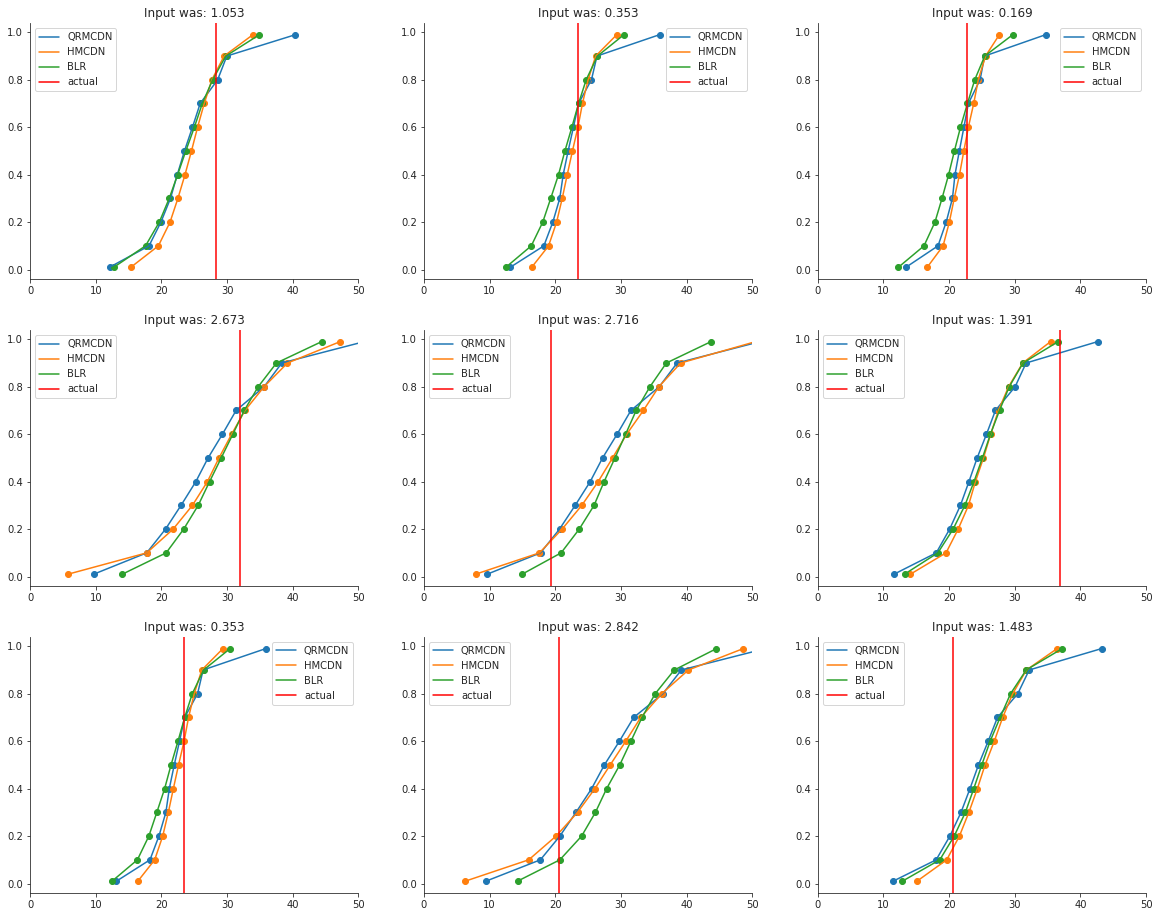

In [10]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))

for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    
    for j, (m_name, preds) in enumerate(qpreds.items()):
        ax.plot(preds[i], QUANTILES, label=m_name, color=cs[j])
        ax.scatter(preds[i], QUANTILES, color=cs[j])

    ax.axvline(y_test[i], color='red', label='actual')
    ax.set_title(f"Input was: {x_test[i][0]:.3f}")
    ax.legend()
    ax.set_xlim(0, 50)

plt.show()

## Secondly, generating distributions

The other way around. Create an approximate posterior distribution from the output of the `QuantileRegressionMCDropoutNet`. Then we can compare it with the output from the `BayesianLinearRegression` and the `HeteroscedasticMCDropoutNet.

In [11]:
posterior_samples = trainer.generate_posterior_samples(x_test, sample_kwargs={'BLR': {'samples': 1000}})

print(*(f'{name}: {output.shape}' for name, output in posterior_samples.items()))

INFO:src.model.model_trainer:Start predicting using model: QRMCDN
INFO:src.model.model_trainer:Done predicting.
INFO:src.model.model_trainer:Start predicting using model: HMCDN
INFO:src.model.model_trainer:Done predicting.
INFO:src.model.model_trainer:Start predicting using model: BLR
100%|██████████| 1000/1000 [00:24<00:00, 41.11it/s]
INFO:src.model.model_trainer:Done predicting.


QRMCDN: (100, 1000) HMCDN: (100, 1000) BLR: (100, 1000)


### Plotting the approximate posterior distributions

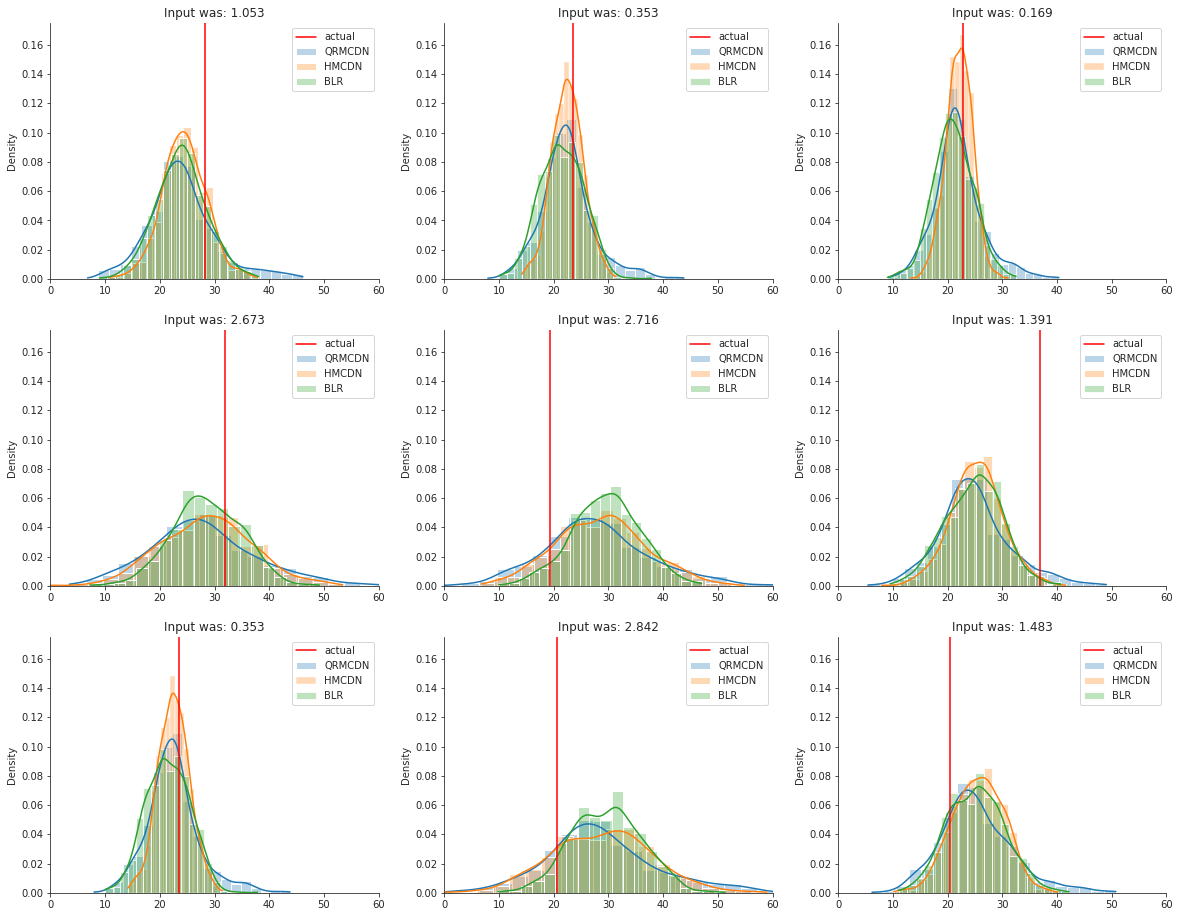

In [12]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))

for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    
    for j, (m_name, samples) in enumerate(posterior_samples.items()):
        sns.histplot(samples[i], bins=20, label=m_name, stat='density', alpha=.3, kde=True, color=cs[j], ax=ax)
    
    ax.set_title(f"Input was: {x_test[i][0]:.3f}")
    ax.axvline(y_test[i], c='r', label='actual')
    ax.legend()
    ax.set_xlim(0, 60)
    
plt.show()

The point estimates predictions are really similar!

In [13]:
for m_name, preds in qpreds.items():
    error = mean_absolute_error(y_test, np.mean(preds, axis=1))
    print(f"MAE - {m_name}\t: {error:.3f}")

MAE - QRMCDN	: 3.831
MAE - HMCDN	: 3.903
MAE - BLR	: 4.012


## The (continuous) ranked probability score

A metric to show how well a predicted distribution is, compared to a single value outcome. This metric calculates (or approximates) the area between the predicted distribution (represented as CDF) and the actual value (represented as Heavyside step function). The smaller this area, the better the predicted distribution fits reality.

![](https://robertsy.github.io/ensemble-da/assets/img/crps-graph.jpg)
[picture source](https://robertsy.github.io/ensemble-da/assets/img/crps-graph.jpg)

In [14]:
import properscoring as ps

for m_name, preds in qpreds.items():
    crps = ps.crps_ensemble(y_test.flatten(), preds, issorted=True).mean()
    print(f'{m_name} CRPS: {crps:.3f}')

QRMCDN CRPS: 2.898
HMCDN CRPS: 2.814
BLR CRPS: 2.925


## Calibration
Now we know how to evaluate a predicted distribution with a single true value, but how well does the distribution represent reality? Then you can compare how well this quantile fits the actual quantile. In other words, when predicting the median (quantile .5) we expect that these predictions overpredict in 50% of the cases. The same holds for the other quantiles. If you calculate this for a set of quantiles, you can make the following plot:

Text(0.5, 1.0, 'Calibration plot - toy dataset')

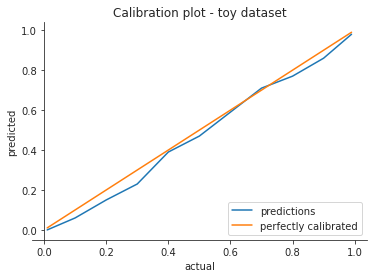

In [26]:
from src.evaluate.plots import plot_quantile_calibration

ax = plot_quantile_calibration(y_test.flatten(), preds, QUANTILES)